In [1]:
using Revise
# Tensor_trains 
using TensorTrains, TensorCast, Tullio, LogarithmicNumbers, ProgressMeter, LinearAlgebra
using TensorTrains: compress!, TruncBondThresh  
using Printf

# MonteCarlo
using Random, Statistics, Distributions

# Graphics
using Plots, Colors

includet("../GlauberPT.jl/src/monte_carlo_efficient/observables.jl")
includet("../GlauberPT.jl/src/monte_carlo_efficient/parameters.jl")
includet("../GlauberPT.jl/src/monte_carlo_efficient/plots.jl")
includet("../GlauberPT.jl/src/monte_carlo_efficient/swap_criteria.jl")
includet("../GlauberPT.jl/src/monte_carlo_efficient/update_rules.jl")
includet("../GlauberPT.jl/src/monte_carlo_efficient/monte_carlo_general.jl")

includet("../GlauberPT.jl/src/tensor_train_efficient/auxiliary_tensor_train_tools.jl")
includet("../GlauberPT.jl/src/tensor_train_efficient/boltzmann_distribution_tt.jl")
includet("../GlauberPT.jl/src/tensor_train_efficient/efficient_observables.jl")
includet("../GlauberPT.jl/src/tensor_train_efficient/initialization_params.jl")
includet("../GlauberPT.jl/src/tensor_train_efficient/metropolis_swap_tt.jl")
includet("../GlauberPT.jl/src/tensor_train_efficient/tensor_train_evolution.jl")
includet("../GlauberPT.jl/src/tensor_train_efficient/transition_rates_builder.jl")

In [4]:
function boltzman_swap_tt(params)
    beta = params.betas[2] - params.betas[1]
    params_1 = MCParameters(
        N = params.N,
        betas = [params.betas[2] - params.betas[1]],  # Nuevo array, no modifica el original
        j_vector = params.j_vector,
        h_vector = params.h_vector
    )
    params_2 = MCParameters(
        N = params.N,
        betas = [params.betas[1] - params.betas[2]],  # Nuevo array, no modifica el original
        j_vector = params.j_vector,
        h_vector = params.h_vector
    )
    mult_sep(boltzman_tt(params_1), boltzman_tt(params_2))
end



function energy_difference(params, x)
    σ = x -> 2x - 3
    e_diff = params.h_vector[1] * (σ(x[1][1]) - σ(x[1][2]))
    N = params.N   
    for i in 1:N-1
        s_i, s_i_prima = x[i]
        s_j, s_j_prima = x[i+1]
        e_diff += params.j_vector[i] * (σ(s_i) * σ(s_j)  - σ(s_i_prima) * σ(s_j_prima)) + params.h_vector[i+1] * (σ(s_j) - σ(s_j_prima))   
    end
    e_diff *= params.betas[2] - params.betas[1]
    return exp(e_diff)
end

energy_difference (generic function with 1 method)

4.913617201920267e-15
4.973799150320701e-14


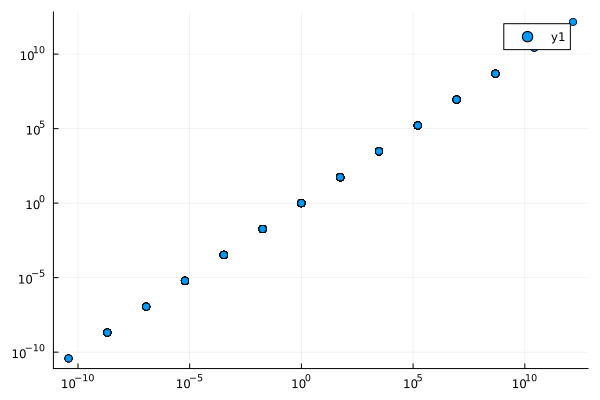

In [10]:
#### Energy Tensor Train Revisar si functiona bien

Revise.revise()
n = 10
params = MCParameters(
    N = n,
    betas = [1.0, 3.0],
    j_vector = ones(n-1),
    h_vector = zeros(n),
    s = 0.15
)

B = boltzman_swap_tt(params)

X = [[[rand(1:2) rand(1:2)] for i in 1:length(B)] for _ in 1:1000]
Y = [[2*(y-1) + x for (x,y) in X[i]] for i in 1:length(X)]
error_sample = maximum(abs.([evaluate(B,x) for x in Y] .- [energy_difference(params, x) for x in X]))
avg_error = mean(abs.([evaluate(B,x) for x in Y] .- [energy_difference(params, x) for x in X]))
println(avg_error)
println(error_sample)
scatter([energy_difference(params, x) for x in X], [evaluate(B,x) for x in Y], yaxis=:log, xaxis=:log)

In [103]:
# Revise.revise()

n = 10
params = MCParameters(
    N = n,
    betas = [1.0, 3.0],
    j_vector = rand(n-1),
    h_vector = rand(n),
    s = 0.15
)

bond = 7
aproximation_number = 5
# swap_tt = tt_swap(params, aproximation_number, bond)
boltzman_tt_ = boltzman_swap_tt(params)

TensorTrain{Float64, 4, Array{Float64, 4}, LogFloat64}([[1.0 8.550694222266706 0.11694956853864781 1.0;;; 2.6598904970816495 22.74391030525818 22.74391030525818 194.47622243892332;;;; 0.375955326393011 0.04396781321146915 0.04396781321146915 0.005142016784669176;;; 1.0 0.11694956853864781 8.550694222266706 1.0], [1.0 1.1820257559700906 0.8460052540727407 1.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0;;; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 1.223017983276485 1.445638756247403 1.445638756247403 1.708782243712998; 0.0 0.0 0.0 0.0;;;; 0.0 0.0 0.0 0.0; 0.8176494652359761 0.6917357435794026 0.6917357435794026 0.5852120734980887; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0;;; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 1.0 0.8460052540727407 1.1820257559700906 1.0], [1.0 4.896145440439101 0.20424229879705472 1.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0;;; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.2301195647014548 1.1266988574688588 1.1266988574688588 5.516481473744097; 0.0 0.0 0.0 0.0;;;

In [45]:
"""
    plot_two_sextuples(times, Sdots, Slines; site_labels=nothing, savepath=nothing)

Grafica dos series temporales de vectores por sitio:
- `times`: vector de tiempos (length T)
- `Sdots`: datos para graficar como puntos — forma N×T o T×N
- `Slines`: datos para graficar como líneas — forma N×T o T×N

Cada fila i corresponde al sitio i. Si la entrada viene en orientación time×sites,
la función la transpone automáticamente.

Opciones:
- `site_labels`: vector de etiquetas para leyenda (por defecto "Sitio 1", ...).
- `savepath`: si no es `nothing` guarda la figura en ese archivo (PNG, PDF, ...).
"""
function plot_two_Ntuples(times, Sdots, Slines; site_labels=nothing, titled="Marginal expectation per spin over steps", savepath=nothing)
    # Normalizar formatos: queremos N × T
    if size(Sdots,1) == length(times) && size(Sdots,2) != length(times)
        Sdots = permutedims(Sdots)   # T×N -> N×T
    end
    if size(Slines,1) == length(times) && size(Slines,2) != length(times)
        Slines = permutedims(Slines)
    end

    @assert size(Sdots) == size(Slines) "Sdots y Slines deben tener la misma forma"
    N, T = size(Sdots)
    @assert length(times) == T "length(times) debe coincidir con número de columnas en Sdots/Slines"

    # Etiquetas por sitio
    if site_labels === nothing
        site_labels = ["Sitio $i" for i in 1:N]
    else
        @assert length(site_labels) == N "site_labels debe tener longitud N"
    end

    cols = distinguishable_colors(N)  # paleta con N colores distinguibles

    p = plot(title=titled,
             xlabel="Tiempo", ylabel="Valor",
             legend=:outerright, grid=true, size=(900,500))

    # Dibujar: línea para Slines (con label) y puntos para Sdots (sin duplicar labels)
    for i in 1:N
        plot!(p, times, Slines[i, :],
              color=cols[i], linewidth=2, label=site_labels[i])
        scatter!(p, times, Sdots[i, :],
                 color=cols[i], marker=:circle, markersize=4, label=false)
    end

    if savepath !== nothing
        savefig(p, savepath)
    end

    return p
end

plot_two_Ntuples

In [ ]:
## Los observables no dan aun

Revise.revise()

n = 10
bond = 8
P0 = [[0.0, 0.0, 0.0, 1.0] for _ in 1:n]
swap = 0.1

params = MCParameters(
    N = n,
    betas = [0.5, 2.0],
    j_vector = ones(n-1),
    h_vector = zeros(n),
    s = swap
)

A= parallel_transition_tensor_train( params; update_rule = :parallel)

T = 30

B_tt = distribution_b_tt(
    A, 
    P0, 
    T, 
    bond,
    ConstantSwap(swap),
    true
    )

B_obs = system_description_over_time(B_tt, params)



initial_probs_ = fill(1.0, n)

# Correr simulación
result_parallel_swap_metropolis = run_monte_carlo_general(
    params,
    N_samples = 1000,
    initial_probs = initial_probs_,
    T_steps = T,
    update_rule = :parallel,                     # :parallel, :sequential, :metropolis
    swap_criterion = :fixed_rate,                # :fixed_rate, :metropolis
    observables = [:magnetization, :energy]
)

result_parallel_swap_metropolis[:observables]

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Dict{Symbol, Any} with 4 entries:
  :energy          => [-9.0 -5.298 … 0.052 -0.01; -9.0 -8.454 … -0.312 -0.248]
  :energy_error    => [0.0 0.101406 … 0.128177 0.128654; 0.0 0.0551533 … 0.1882…
  :energy_variance => [0.0 10.2832 … 16.4293 16.5519; 0.0 3.04188 … 35.4547 34.…
  :magnetization   => [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;; 0.512 0.77 … 0.7…

In [8]:
result_parallel_swap_metropolis[:observables][:energy]

2×31 Matrix{Float64}:
 -9.0  -5.298  -3.372  -2.376  -1.89  …  -0.434  -0.39   0.052  -0.01
 -9.0  -8.454  -7.866  -7.088  -6.46     -0.396  -0.26  -0.312  -0.248

In [9]:
B_obs.energy_t

31-element Vector{Any}:
 (-9.0, -9.0)
 (-3.9491099254020434, -8.365345865729102)
 (-2.329471340847427, -7.61459245147066)
 (-1.6488542700495377, -6.931095687761792)
 (-1.333596475312245, -6.284913723217138)
 (-1.161723371946897, -5.598949754621076)
 (-1.060928927375439, -5.063719896401748)
 (-0.9822439876303514, -4.600087780997782)
 (-0.9195718243736887, -4.188480459220302)
 (-0.8648619694500661, -3.8219098363753785)
 ⋮
 (-0.2410914733267207, -1.2284265234360128)
 (-0.22410291348323547, -1.1261096105288178)
 (-0.20954578826539594, -1.0328549549413872)
 (-0.19703202859924762, -0.9478933516136973)
 (-0.1860780946460936, -0.87045225497297)
 (-0.17634050911219207, -0.7998788448484524)
 (-0.167468176344021, -0.735525468486647)
 (-0.15918711128060742, -0.6768454986091824)
 (-0.15126408562979732, -0.6232996744637859)

In [10]:
# B_t_plus_fixed = tensor_b_t_over_time(A_plus, P0, T, max_bound)

# mag_tt_time = [marginal_ev_parallel_system(B_t_plus_fixed[k]) for k in 1:T]

# print("done")